# "MixUp: copy"
> "A dive into the implementation"

- toc: false
- badges: false
- comments: true
- categories: [fastai, mixup]
- hide: false

In this post, we get to know the benefits of using mixup and how to implement it in practice. We dive into the official implementation of the MixUp paper and compare it to the implementation of the famous [fastai](https://github.com/fastai/fastai) library. 

Mixup was introduced in this [paper](https://arxiv.org/abs/1710.09412). Mixup is a simple technique for data augmentation, yet it has several advantages. As stated by the authors, mixup does: 
* regularize neural networks to favor simple linear behavior among training examples. 
* improve the generalization of state-of-the-art neural network architectures. 
* reduce the memorization of corrupt labels.
* increase the robustness to adversarial examples.
* stabilize the training of generative adversarial networks (GANs).

The contributions from paper can be summarized by the following snapshot. 

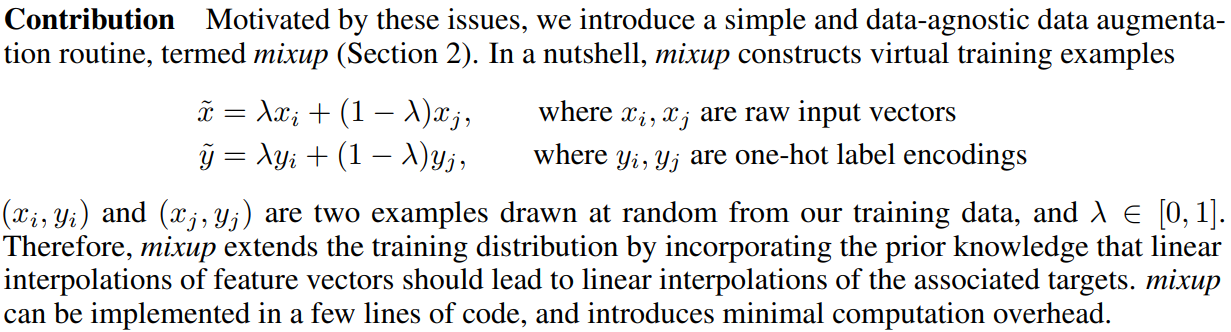

## How can we implement mixup in practice?
The [fastbook](https://github.com/fastai/fastbook/blob/master/07_sizing_and_tta.ipynb), by Jeremy Howard and Sylvain Gugger, does a great job in simplifying the concept. Essentially, mixup can be implemented with 4 simple steps; for each image:
1.	Select another image from the dataset at random.
2.	Pick a random weight.
3.	Take a weighted sum (i.e., a linear combination) of the selected image with the original image. This will form the independent variable.
4.	Take a weighted sum (using the same weight from step 2) of the labels of those two images. This will produce the dependent variable.

There is one additional requirement that the labels have to be one-hot encoded.


This sound really great!

### Official implementation 

Let's check the corresponding [code](https://github.com/facebookresearch/mixup-cifar10/blob/master/train.py) from the official implementation of the paper. 

The random weight is sampled from Beta distribution

`lam = np.random.beta(alpha, alpha)`

In practice, the random images are selected from within a mini batch rather than the whole dataset for convenience. 

`index = torch.randperm(batch_size)`

The inputs are then mixep using a weighted sum with a random permutation of those same inputs

`mixed_x = lam * x + (1 - lam) * x[index, :]`

So far so good. 

However, when we come to the point of mixing the labels we notice a deviation from the description above.

`y_a, y_b = y, y[index]`

we notice that labels are not being mixed when preparing the data. In addition, labels are not one-hot encoded in this particular case. We can confirm this by examining the loss function being used. 

```
criterion = nn.CrossEntropyLoss()
def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)
```
`CrossEntropyLoss` as defined in [Pytorch](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) does not accept one-hot encoded labels. We also notice a weighted sum of losses with respect to the original labels `y_a` and the permutation labels `y_b`, rather than the loss between predictions and a weighted some of labels. 

what is wrong here?

Actually, there is nothing wrong! It turns out that this implementation is equivalent to the previous description. It is just easier to exploit this fact and use the existing labels and loss function (i.e., there is no need to convert labels to be one-hot encoded or change the loss function to accept such labels).

We will confirm this fact with a simplistic example. 

Let `pred` be a batch of 4 predictions corresponding to mixed inputs `mixed_x`, `y_a` a batch of labels associated with the original inputs, and `y_b` a batch of labels associated with permuted inputs. 




In [ ]:
!pip install -Uqq fastai

     |████████████████████████████████| 188 kB 9.3 MB/s 
     |████████████████████████████████| 56 kB 2.6 MB/s 


In [ ]:
from fastai.basics import *

In [ ]:
# predictions of a small batch of size 4
pred = tensor([[0.8, 0.2], [0.7,0.3], [0.4,0.6], [0.6, 0.4]])
pred

tensor([[0.8000, 0.2000],
        [0.7000, 0.3000],
        [0.4000, 0.6000],
        [0.6000, 0.4000]])

In [ ]:
# original labels
y = tensor([0,0,1,1])
y

tensor([0, 0, 1, 1])

In [ ]:
# random permutation a batch
batch_size = 4
index = torch.randperm(batch_size)
index

tensor([0, 3, 2, 1])

In [ ]:
# original and permuted labels 
y_a, y_b = yb, yb[index]
y_a, y_b

(tensor([0, 0, 1, 1]), tensor([0, 1, 1, 0]))

In [ ]:
# weight
lam = tensor(0.3)
lam

tensor(0.3000)

In [ ]:
# loss as computed by the official implementation 
loss = nn.CrossEntropyLoss(reduction="none")
def mixup_loss(loss, pred, y_a, y_b, lam):
  return lam * loss(pred, y_a) + (1 - lam) * loss(pred, y_b)

In [ ]:
mixup_loss(loss, pred, y_a, y_b, lam)

tensor([0.4375, 0.7930, 0.5981, 0.6581])

To this point, we obtained the loss as computed by the official implementation. We set the *reduction* to `"none"` in order to show all the components of the loss. However, the mean of those values should be computed in practice. 

In the following section, we will implement the loss as described in fastbook and in the paper. 

In [ ]:
# convert labels to one-hot encoding
one_hot_y_a = tensor([[1, 0], [1, 0], [0, 1], [0, 1]])
one_hot_y_a

tensor([[1, 0],
        [1, 0],
        [0, 1],
        [0, 1]])

In [ ]:
# convert labels to one-hot encoding
one_hot_y_b = tensor([[1, 0], [0, 1], [0, 1],  [1, 0]])
one_hot_y_b

tensor([[1, 0],
        [0, 1],
        [0, 1],
        [1, 0]])

In [ ]:
# compute mixed lables
mixed_y = lam * one_hot_y_a + (1 - lam) * one_hot_y_b
mixed_y

tensor([[1.0000, 0.0000],
        [0.3000, 0.7000],
        [0.0000, 1.0000],
        [0.7000, 0.3000]])

We notice here that the first and the third labels did not change when compared with the original labels. This is because we are mixing with the same labels in these cases. 

Next, we define a version of the cross entropy loss that accepts one-hot encoded labels (or a weighted sum of one-hot encoded labels to be precise; those are also called soft labels as opposed to hard labels i.e., zero or one).

In [ ]:
# https://discuss.pytorch.org/t/cross-entropy-with-one-hot-targets/13580/5
def one_hot_CELoss(pred, target):
  logsoftmax = nn.LogSoftmax()
  return torch.sum(-target * logsoftmax(pred), dim=1)

In [ ]:
one_hot_CELoss(pred, mixed_y)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until


tensor([0.4375, 0.7930, 0.5981, 0.6581])

In [ ]:
test_close(one_hot_CELoss(pred, mixed_y) , mixup_loss(loss, pred, y_a, y_b, lam))

Hooray! The results are matching. 

### Fastai Implementation
Fastai follows the official implementation of drawing the random images from the mini batch. The [code](https://github.com/fastai/fastai/blob/master/fastai/callback/mixup.py) looks a bit different as fastai uses some functionalities of the `L` class from [fastcore](https://fastcore.fast.ai/). 
```
shuffle = torch.randperm(self.y.size(0)).to(self.x.device)
xb1,self.yb1 = tuple(L(self.xb).itemgot(shuffle)),tuple(L(self.yb).itemgot(shuffle))
```
Similarly, fastai's implementation mixes the inputs and takes a mix of losses instead of mixing one-hot encoded labels. 

`self.learn.xb = tuple(L(xb1,self.xb).map_zip(torch.lerp,weight=unsqueeze(self.lam, n=nx_dims-1)))`

`loss = torch.lerp(lf(pred,*self.yb1), lf(pred,*yb), self.lam)`

But wait a minute! 

Looks like there is no weighted sum in here. We notice the use of `torch.lerp` instead. If you look up the [documentation](https://pytorch.org/docs/stable/generated/torch.lerp.html) of `torch.lerp`, you will find out the it does something like this: 

```torch.lerp(input, end, weight, *, out=None)```

$out_{i} = input_{i} + weight_{i} \times (end_{i}-input_{i})$

with simple refactoring we can see that: 

$out_{i} = input_{i} + weight_{i} \times end_{i} - weight_{i} \times input_{i}$

$out_{i} = (1-weight_{i}) \times input_{i} + weight_{i} \times end_{i}$

which is the weighted sum of the two tensors `input` and `end`. 

But why not simply use a clear weighted sum instead of `torch.lerp`?!

The answer is performance! Pytorch has very optimized low level implementations for certain operations which is usually much faster. Let's confirm this with a little experiment. 




In [ ]:
# random input tensors
a = torch.randn((64,400,400))
b = torch.randn((64,400,400))

In [ ]:
# simple weighted sum implementation
%timeit -n100 ((1-lam)*a + lam*b)

100 loops, best of 5: 32.6 ms per loop


In [ ]:
# torch.lerp implementation of the weighted sum
%timeit -n100 torch.lerp(a,b,lam)

100 loops, best of 5: 12.7 ms per loop


In [ ]:
32.6/12.7

2.566929133858268

we can see over 2.5X speed-up boost when using `torch.lerp`. And since we are talking about ***fast***ai, it's better be using `torch.lerp`. 